### Working with RSpace data.

This notebook illustrates a workflow to get data from RSpace, analyse it, and send back results to RSpace.
To work with this tutorial, you'll need an account on RSpace, an RSpace API key and Python 3.6 or later.

This project requires modules `rspace_client` (Version 2) , `pandas` and `matplotlib`.

To install rspace client `pip install rspace-client==2.0.1`

The top-level README.md has more information on getting set up. 

The notebook is split into 3 sections:

1. Adding some data to RSpace to analyse. In reality, this might be done manually by a wet-lab scientist or be delivered programmatically by an instrument. 
2. Getting the datasets to analyse
3. Sending back the  analysis linked to an experimental record

#### Setup Step 1 - configuring the RSpace Client. `rspace_client` is available from pip.

It's good practice to store API keys as environment variables rather than hard-coding it.

In [13]:
from rspace_client.eln import eln
import os


#API_KEY=os.environ.get('RSPACE_API_KEY')
#URL=os.environ.get('RSPACE_URL')
URL='https://pangolin8086.researchspace.com'
API_KEY='xxxxxxxxx'

api = eln.ELNClient(URL, API_KEY)

## sanity check that that the client is configured correctly
api.get_status()

{'message': 'OK', 'rspaceVersion': '1.72.0-2021-11-05T16:52:49Z'}

#### Setup Step 2 - adding some test data.

Here we'll add a CSV file to RSpace, containing some synthetic weather-related data.

In [14]:
with open ('temp_data.csv') as f:
    raw_data_file = api.upload_file(f)['id']
raw_data_file_id= raw_data_file
print(raw_data_file_id)

174


#### Analysis Step 1 - retrieving dataset

OK, now we can start working with this dataset. If this dataset had been uploaded by a colleague, we could have been notified by Slack, Teams, email or within RSpace itself that this file was available for analysis.

In [15]:
file_name = "downloaded_"+(api.get_file_info(raw_data_file_id)['name'])
print(file_name)

## retrieve from RSpace - here we are downloading the file
raw_temp_data = api.download_file(raw_data_file_id, file_name)

downloaded_temp_data.csv


#### Analysis Step 2 - the analysis

Here is where you do your actual analysis of the data... here we'll just plot the data and generate a summary, saving both to file.

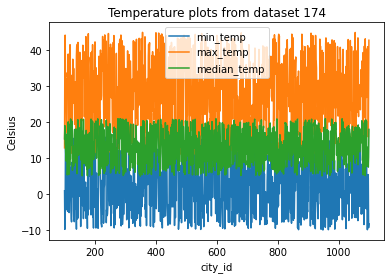

In [16]:
import pandas as pd;
df = pd.read_csv(file_name)
summary_stats = df.describe()

df = df.set_index('city_id')
plot = df.plot(ylabel='Celsius', title=f'Temperature plots from dataset {raw_data_file_id}')
img_f= f'Temperature_per_city-{raw_data_file_id}'
plot.get_figure().savefig(img_f)

summary_stats_csv = f'{file_name[:file_name.rindex(".")]}-summarystats.csv'
summary_stats.to_csv(summary_stats_csv)

#### Analysis Step 3 - uploading back to RSpace

You can add captions to the file to help describe your analysis.

In [18]:
with open(summary_stats_csv, 'rb') as f:
    summary_file = api.upload_file(f, caption=f"Summary data for {raw_data_file_id}")
    print(f"uploaded id = {summary_file['id']}")
with open(img_f+".png", 'rb') as f:
    uploaded_image = api.upload_file(f, caption=f"City vs temperature for  {raw_data_file_id}")
    print(f"uploaded id = {uploaded_image['id']}") 

uploaded id = 175
uploaded id = 176


There are several  options now:

* You can create an RSpace document, and insert these files, and share the document with your group or colleage. 
* Your colleagues may have already created and shared document describing an experiment that generated these files, in which case you would already have access to a document.

Here we'll go with a simple flow where we create a new RSpace document to share with the rest of our research group.

The content we'll insert will be HTML. However you don't need to figure out how to display the linked files. Just include file links as `<fileId=XXXX>` syntax and RSpace will turn these into formatted links.


In [19]:
new_doc = api.create_document(name=f"Analysis of dataset {raw_data_file_id}")
content = f"""
<p>Analysis of temperature dataset from our standard locations.
<p>No variation between locations:
Raw data: <fileId={raw_data_file_id}>
<p>
Statistical summary: <fileId={summary_file['id']}>
<p>
Location vs temperature: <fileId={uploaded_image['id']}>
"""

updated_doc = api.append_content(new_doc['id'], content)

## a simple utility function so you can get a link to view the updated contents in a browser.
def api_to_browser(link):
    return '/globalId/SD'.join(link.split('/api/v1/documents/'))

print(f"You can view this in a browser at {api_to_browser(updated_doc['_links'][0]['link'])}")


You can view this in a browser at https://pangolin8086.researchspace.com/globalId/SD177


If you're in a  group, you can now share this with your group. You can get your groups' IDs: 

In [20]:
groups = api.get_groups()

In [21]:
api.shareDocuments([new_doc['id']], groups[0]['id'], permission="EDIT")

IndexError: list index out of range